In [1334]:
#%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import scipy.stats as stat
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from multiprocessing import Pool
from scipy import stats
import math
from scipy.optimize import curve_fit
from mpl_toolkits import mplot3d
from scipy.ndimage import gaussian_filter1d
import statsmodels.api as sm
from statsmodels.formula.api import ols

## Base Model
$e_n^{target} = (r_n - r_n^{est})$

$r_{n+1}^{est} = Ar_n^{est} + Be_n^{target}$

In [1319]:
num_trials = 640
def base_model_sudden(num_trials, A, B):
 #   A = np.exp(A)/(1 + np.exp(A))
 #   B = np.exp(B)/(1 + np.exp(B))
    
    errors = np.zeros((num_trials))
    rotation = 90
    rotation_est = 0
    for trial in range(num_trials):
        errors[trial] = rotation - rotation_est
        #print(errors[trial])
        rotation_est = A*rotation_est + B*errors[trial]
        #print (rotation_est)
    return errors

def base_model_gradual(num_trials, A, B):
#    A = np.exp(A)/(1 + np.exp(A))
#    B = np.exp(B)/(1 + np.exp(B))
    
    errors = np.zeros((num_trials))
    rotation_est = 0
    rotation = 0
    for trial in range(num_trials):
        if trial%64 == 0:
            rotation = rotation + 10
        if rotation > 90:
            rotation = 90
        errors[trial] = rotation - rotation_est
        #print(errors[trial])
        rotation_est = A*rotation_est + B*errors[trial]
        #print (rotation_est)
    return errors

In [1332]:
def base_model_transfer(num_trials, A, B, learned_rotation):
 #   A = np.exp(A)/(1 + np.exp(A))
 #   B = np.exp(B)/(1 + np.exp(B))
    
    errors = np.zeros((num_trials))
    rotation = 90 - learned_rotation
    rotation_est = 0
    for trial in range(num_trials):
        errors[trial] = rotation - rotation_est
        #print(errors[trial])
        rotation_est = A*rotation_est + B*errors[trial]
        #print (rotation_est)
    return errors


# Data
## Curvatures

In [966]:
def calc_angle(current_point, next_point, final_point):
    #vec1 = next_point - current_point
    vec1 = np.subtract(next_point, current_point)
#    vec2 = final_point - current_point
    vec2 = np.subtract(final_point, current_point)
    vec1 = vec1.astype('float64')
    vec2 = vec2.astype('float64')
    cos_theta = np.dot(vec1, vec2)/(np.linalg.norm(vec1) * np.linalg.norm(vec2))
    theta = np.degrees(np.arccos(cos_theta))
    return theta

def calc_curvature(data, block, trial, percentage_trajectory):
    traj = scipy.io.loadmat('data/data{data}/actual_trajectories/trajectories{block}.mat'.format(block=str(block), data=str(data)))
    trajx, trajy = traj['x'][0][trial][0], traj['y'][0][trial][0]
    targetx, targety = trajx[-1], trajy[-1]
    partial_trajx, partial_trajy = get_partial_traj(data, block, trial, percentage_trajectory)
    #print (trajx)
    #print (trajy)
    angles = list([0])
    for i in range(len(partial_trajx[:-1])):
        #print (trajx[i], trajy[i])
        angles.append(calc_angle(np.array([partial_trajx[i], partial_trajy[i]]), np.array([partial_trajx[i+1], partial_trajy[i+1]]), np.array([trajx[-1], trajy[-1]])))
    return np.nanmedian(angles)

def get_traj(data, block, trial):
    traj = scipy.io.loadmat('data/data{data}/actual_trajectories/trajectories{block}.mat'.format(block=str(block), data=str(data)))
    x_traj = traj['x'][0][trial][0]
    y_traj = traj['y'][0][trial][0]
    return x_traj, y_traj

def get_partial_traj(data, block, trial, percentage_trajectory):
    traj = get_traj(data, block, trial)
    dist_cutoff = percentage_trajectory*np.sqrt(traj[0][-1]**2 + traj[0][-1]**2, dtype = float)
    for i in range(len(traj[0])):
        dist_from_start = np.sqrt(traj[0][i]**2 + traj[1][i]**2, dtype = float)
        if dist_from_start > dist_cutoff:
            break
    partial_trajx = traj[0]#[:i]
    partial_trajy = traj[1]#[:i]
        
            
    return partial_trajx, partial_trajy



In [946]:
curvatures = np.zeros((60, 12, 64))
for data in range(60):
    for block in range(12):
        for trial in range(64):
            curvatures[data][block][trial] = calc_curvature(data+1000, block, trial, 1)
    if data%10 == 0:
        print (data)

C:\Users\Tejas\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in arccos
  if __name__ == '__main__':
C:\Users\Tejas\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


0
10
20
30
40
50


In [947]:
calc_curvature(1002, 0, 4, 1)

0.8012873301080647

In [930]:
#np.dot([25, 20], [187, 164])/(np.linalg.norm([25, 20]) * np.linalg.norm([187, 164]))
np.dot(np.array([25, 20]), np.array([187, 164]))


7955

In [923]:
a = [25, 20]
b = [187, 164]
np.dot(a, b)

7955

In [1256]:
def residuals_base_sudden(params, num_trials, data_errors):
#   model_errors = base_model_sudden(num_trials, params[0], params[1])
    model_errors = base_model_sudden(num_trials, params[0], params[1])
    residual_error = np.sum(np.square(model_errors - data_errors))
    #if params[0] > params[2]:
    #    residual_error = residual_error + 1000000
    #if params[1] < params[3]:
    #    residual_error = residual_error + 1000000
    if params[0] < 0 or params[1] < 0:# or params[2] < 0 or params[3] < 0:
        residual_error = residual_error + 1000000
    return residual_error

def residuals_base_gradual(params, num_trials, data_errors):
#   model_errors = base_model_sudden(num_trials, params[0], params[1])
    model_errors = base_model_gradual(num_trials, params[0], params[1])
    residual_error = np.sum(np.square(model_errors - data_errors))
    #if params[0] > params[2]:
    #    residual_error = residual_error + 1000000
    #if params[1] < params[3]:
    #    residual_error = residual_error + 1000000
    if params[0] < 0 or params[1] < 0:# or params[2] < 0 or params[3] < 0:
        residual_error = residual_error + 1000000
    return residual_error

In [1257]:
#Divide the whole thing into 16 trial blocks and fit them
def run_fits(curvatures, num_trials, part_size, first):
    num_parts = int((num_trials-first)/part_size)
    fit_A = np.zeros((60, num_parts))
    fit_B = np.zeros((60, num_parts))
    fit_V = np.full((60, num_parts), np.inf)
    fit_success = np.zeros((60, num_parts))
    fit_num = 0
    #starting_points = np.array([[0.5, 0.6], [0.4, 0.7], [0.3, 0.8], [0.2, 0.9], [0.1, 0.99], [0.9, 0.2], [0.99, 0.1], [0.8, 0.3], [0.7, 0.4], [0.6, 0.5]])
    
    #A = np.log(params[0]/(1-params[0]))
    #B = np.log(params[1]/(1-params[1]))

#    starting_points = np.array([[np.log(0.999/(1 - 0.999)), np.log(0.002/(1 - 0.002))]])
    starting_points = np.array([[0.999, 0.002]])

    for curr_trial in range(first, num_trials, part_size):
        for participant in range(60):
            for initial_point in starting_points:
                if participant%4 == 0 or participant%4 == 1:
                #print (np.nan_to_num(np.ravel(curvatures[participant])[first:first+part_size], nan = np.nanmedian(np.ravel(curvatures[participant])[first:first+part_size])))
                #popt, pcov = curve_fit(base_model_sudden, part_size, np.nan_to_num(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size], nan = np.nanmedian(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size])), bounds=((0, 0), (1, np.inf)))
                    #fits = scipy.optimize.minimize(residuals_base_sudden, x0 = [initial_point[0], initial_point[1]], args = (part_size, np.nan_to_num(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size], nan = np.nanmedian(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size]))), method = 'Nelder-Mead')
                    fits = scipy.optimize.basinhopping(residuals_base_sudden, x0 = [initial_point[0], initial_point[1]], minimizer_kwargs={'args': (part_size, np.nan_to_num(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size], nan = np.nanmedian(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size]))), 'method': 'Nelder-Mead'}, stepsize=0.05)
                    
                    if fits.fun < fit_V[participant][fit_num]:
                        fit_A[participant][fit_num] = fits.x[0]
                        fit_B[participant][fit_num] = fits.x[1]
                        fit_V[participant][fit_num] = fits.fun
                        #fit_success[participant][fit_num] = fits.success   
                    print (fits.fun)
                else:
                    #popt, pcov = curve_fit(base_model_gradual, part_size, np.nan_to_num(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size], nan = np.nanmedian(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size])), bounds=((0, 0), (1, np.inf)))
                    #fits = scipy.optimize.minimize(residuals_base_gradual, x0 = [initial_point[0], initial_point[1]], args = (part_size, np.nan_to_num(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size], nan = np.nanmedian(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size]))), method = 'Nelder-Mead')
                    fits = scipy.optimize.basinhopping(residuals_base_gradual, x0 = [initial_point[0], initial_point[1]], minimizer_kwargs={'args': (part_size, np.nan_to_num(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size], nan = np.nanmedian(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size]))), 'method': 'Nelder-Mead'})
                    
                    if fits.fun < fit_V[participant][fit_num]:
                        fit_A[participant][fit_num] = fits.x[0]
                        fit_B[participant][fit_num] = fits.x[1]
                        fit_V[participant][fit_num] = fits.fun
                        #fit_success[participant][fit_num] = fits.success
                    print (fits.fun)

        fit_num = fit_num + 1
    return fit_A, fit_B, fit_V, fit_success
        

In [1258]:
curvatures_smooth = gaussian_filter1d(curvatures, 2)
np.shape(curvatures_smooth)

(60, 12, 64)

In [1259]:
fit_A, fit_B, fit_V, fit_success = run_fits(curvatures_smooth, 704, 640, 64)

64021.15323502319


C:\Users\Tejas\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in square
  after removing the cwd from sys.path.


51997.75031553391


C:\Users\Tejas\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in square
  app.launch_new_instance()
C:\Users\Tejas\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:597: RuntimeWarning: invalid value encountered in subtract
  numpy.max(numpy.abs(fsim[0] - fsim[1:])) <= fatol):
C:\Users\Tejas\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


28738.816326181844
16167.86930782385
24003.449842575654
17546.476709674094
6562.357255104592
15347.3650798208
50012.0973030997
69704.79927831984
28728.11770247329
8726.287450731004
62759.27351823197
56423.029360843626
37086.466615873185
4122.174340042394
45776.11228782132
6747.387312624588
24226.08556894921
11411.227359697401
66864.23336307351
38670.09594907944
75264.21145040574
23612.409280809017
66856.68011659861
37506.1959980829
40681.659305479145
30271.399734026425
202983.8096181064
55295.73421353887
29756.52551375515
8217.157454625536
31842.95681975549
44052.13722435634
13874.113993002295
6656.069265318798
195456.1213858142
135178.5122462227
42286.80352280855
5593.903356232555
37759.01632634019
31046.230518491655
90021.50481608059
7039.654857324252
33807.58961211209
92825.24181945469
24972.361975651926
12772.395774356237
123799.11365151877
65715.7211495172
31565.905688142022
16584.584166220426
91546.36674988171
61395.01247671658
50935.89634872334
15151.618988040082
46086.725535491

In [1017]:
#Divide the whole thing into 16 trial blocks and fit them
def run_fits_transfer(curvatures, num_trials, part_size, first):
    num_parts = int((num_trials-first)/part_size)
    fit_A = np.zeros((60, num_parts))
    fit_B = np.zeros((60, num_parts))
    fit_V = np.full((60, num_parts), np.inf)
    fit_success = np.zeros((60, num_parts))
    fit_num = 0
    #starting_points = np.array([[0.5, 0.6], [0.4, 0.7], [0.3, 0.8], [0.2, 0.9], [0.1, 0.99], [0.9, 0.2], [0.99, 0.1], [0.8, 0.3], [0.7, 0.4], [0.6, 0.5]])
    
    #A = np.log(params[0]/(1-params[0]))
    #B = np.log(params[1]/(1-params[1]))

#    starting_points = np.array([[np.log(0.999/(1 - 0.999)), np.log(0.002/(1 - 0.002))]])
    starting_points = np.array([[0.999, 0.002]])

    for curr_trial in range(first, num_trials, part_size):
        for participant in range(60):
            for initial_point in starting_points:
                fits = scipy.optimize.basinhopping(residuals_base_sudden, x0 = [initial_point[0], initial_point[1]], minimizer_kwargs={'args': (part_size, np.nan_to_num(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size], nan = np.nanmedian(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size]))), 'method': 'Nelder-Mead'}, stepsize=0.05)
                if fits.fun < fit_V[participant][fit_num]:
                    fit_A[participant][fit_num] = fits.x[0]
                    fit_B[participant][fit_num] = fits.x[1]
                    fit_V[participant][fit_num] = fits.fun
                    #fit_success[participant][fit_num] = fits.success   
                print (fits.fun)
                #popt, pcov = curve_fit(base_model_gradual, part_size, np.nan_to_num(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size], nan = np.nanmedian(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size])), bounds=((0, 0), (1, np.inf)))
                #fits = scipy.optimize.minimize(residuals_base_gradual, x0 = [initial_point[0], initial_point[1]], args = (part_size, np.nan_to_num(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size], nan = np.nanmedian(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size]))), method = 'Nelder-Mead')
#                fits = scipy.optimize.basinhopping(residuals_base_gradual, x0 = [initial_point[0], initial_point[1]], minimizer_kwargs={'args': (part_size, np.nan_to_num(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size], nan = np.nanmedian(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size]))), 'method': 'Nelder-Mead'})#

#                if fits.fun < fit_V[participant][fit_num]:
#                    fit_A[participant][fit_num] = fits.x[0]
#                    fit_B[participant][fit_num] = fits.x[1]
#                    fit_V[participant][fit_num] = fits.fun
                    #fit_success[participant][fit_num] = fits.success
#                print (fits.fun)

        fit_num = fit_num + 1
    return fit_A, fit_B, fit_V, fit_success
        

In [1018]:
fit_transfer_A, fit_transfer_B, fit_transfer_V, fit_transfer_success = run_fits_transfer(curvatures_smooth, 768, 64, 704)

13184.50494170786
3175.7946098043763
2387.645397586164
3737.5102303689328
5285.738951420718
7010.583668757056
3016.7324679885596
3388.7398566681304
8783.534118105921
6663.158250118232
4068.006833879782
6865.4054218573665
3939.189820103373
6496.691071296313
4184.9714842352905
5544.016651834145
3773.8805105546076
5161.167109783915
1412.0115023046096
6311.771897878286
5455.980846087044
5641.739769310724
2924.1423190983705
5349.190275413527
8287.937683837063
4425.204246222113
4535.9152707006415
4351.841376012335
1863.1394014102552
4201.155683817464
3987.0453469840922
2703.591637916433
4632.961295537151
5021.431113838866
3158.7371102964253
6144.643357873842
1660.6335200935305
5507.732198703753
8276.045229156605
4444.1462425466425
5714.53555470913
7155.632435108976
6157.9031794719
6559.890607542531
7637.2617373924095
5709.144023170416
5591.7958209235
5098.501679871737
6500.624152940096
1101.9115480677035
3141.888085827074
4621.436158631901
8466.983325599653
2420.5349073643806
5582.0236042508

In [1362]:
def plot_fits(fit_A, fit_B, x_label, y_label):
    x = np.array([np.nanmean(fit_A[0::4, :], axis = 0), np.nanmean(fit_A[1::4, :], axis = 0), np.nanmean(fit_A[2::4, :], axis = 0), np.nanmean(fit_A[3::4, :], axis = 0)])
    y = np.array([np.nanmean(fit_B[0::4, :], axis = 0), np.nanmean(fit_B[1::4, :], axis = 0), np.nanmean(fit_B[2::4, :], axis = 0), np.nanmean(fit_B[3::4, :], axis = 0)])
    x_err = np.array([stat.sem(fit_A[0::4, :], axis = 0), stat.sem(fit_A[1::4, :], axis = 0), stat.sem(fit_A[2::4, :], axis = 0), stat.sem(fit_A[3::4, :], axis = 0)])
    y_err = np.array([stat.sem(fit_B[0::4, :], axis = 0), stat.sem(fit_B[1::4, :], axis = 0), stat.sem(fit_B[2::4, :], axis = 0), stat.sem(fit_B[3::4, :], axis = 0)])
    #x_err = np.array([stat.tstd(fit_A[0::4, :], axis = 0), stat.tstd(fit_A[1::4, :], axis = 0), stat.tstd(fit_A[2::4, :], axis = 0), stat.tstd(fit_A[3::4, :], axis = 0)])
    #y_err = np.array([stat.tstd(fit_B[0::4, :], axis = 0), stat.tstd(fit_B[1::4, :], axis = 0), stat.tstd(fit_B[2::4, :], axis = 0), stat.tstd(fit_B[3::4, :], axis = 0)])

    #x_conf_interval = np.array(stat.norm.interval(0.83, loc = x, scale = x_err))
    #y_conf_interval = np.array(stat.norm.interval(0.83, loc = y, scale = y_err))
    x_CI = x - np.array(stat.norm.interval(0.95, loc = x, scale = x_err))[0, :], np.array(stat.norm.interval(0.95, loc = x, scale = x_err))[1, :] - x
    y_CI = y - np.array(stat.norm.interval(0.95, loc = y, scale = y_err))[0, :], np.array(stat.norm.interval(0.95, loc = y, scale = y_err))[1, :] - y


    #print (x_conf_interval[:, 0])
    #plt.errorbar(x, y, xerr = x_err, yerr = y_err, linestyle = 'None', capsize = 3)
    plot0 = plt.errorbar(x[0], y[0], xerr = [x_CI[0][0], x_CI[1][0]], yerr = [y_CI[0][0], y_CI[1][0]], capsize = 3)
    plot1 = plt.errorbar(x[1], y[1], xerr = [x_CI[0][1], x_CI[1][1]], yerr = [y_CI[0][1], y_CI[1][1]], capsize = 3)
    plot2 = plt.errorbar(x[2], y[2], xerr = [x_CI[0][2], x_CI[1][2]], yerr = [y_CI[0][2], y_CI[1][2]], capsize = 3)
    plot3 = plt.errorbar(x[3], y[3], xerr = [x_CI[0][3], x_CI[1][3]], yerr = [y_CI[0][3], y_CI[1][3]], capsize = 3)

    #plot0 = plt.scatter(fit_A[0::4], fit_B[0::4])
    #plot1 = plt.scatter(fit_A[1::4], fit_B[1::4])
    #plot2 = plt.scatter(fit_A[2::4], fit_B[2::4])
    #plot3 = plt.scatter(fit_A[3::4], fit_B[3::4])

    plt.legend((plot0, plot1, plot2, plot3), ('Sudden Speed', 'Sudden Accuracy', 'Gradual Speed', 'Gradual Accuracy'))
    plt.xlabel(x_label)
    plt.ylabel(y_label)

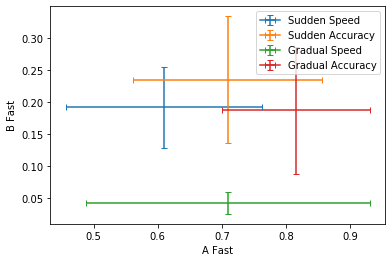

In [1363]:
plot_fits(Af, Bf, "A Fast", "B Fast")

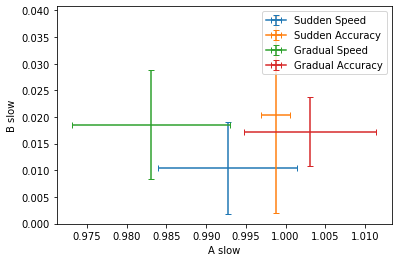

In [1364]:
plot_fits(As, Bs, "A slow", "B slow")

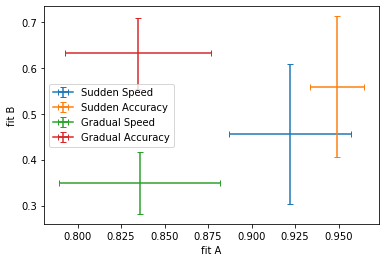

In [1019]:
plot_fits(fit_transfer_A, fit_transfer_B)

In [1376]:
def plot_collapsed_across_rotation_fits(fit_A, fit_B, x_label, y_label):
    x = np.array([np.mean(np.concatenate((fit_A[0::4], fit_A[1::4])), axis = 0),np.mean(np.concatenate((fit_A[2::4], fit_A[3::4])), axis = 0)])
    y = np.array([np.mean(np.concatenate((fit_B[0::4], fit_B[1::4])), axis = 0),np.mean(np.concatenate((fit_B[2::4], fit_B[3::4])), axis = 0)])
    x_err = np.array([stat.sem(np.concatenate((fit_A[0::4], fit_A[1::4])), axis = 0),stat.sem(np.concatenate((fit_A[2::4], fit_A[3::4])), axis = 0)])
    y_err = np.array([stat.sem(np.concatenate((fit_B[0::4], fit_B[1::4])), axis = 0), stat.sem(np.concatenate((fit_B[2::4], fit_B[3::4])), axis = 0)])
    #x_err = np.array([stat.tstd(np.concatenate((fit_A[0::4], fit_A[1::4])), axis = 0),stat.tstd(np.concatenate((fit_A[2::4], fit_A[3::4])), axis = 0)])
    #y_err = np.array([stat.tstd(np.concatenate((fit_B[0::4], fit_B[1::4])), axis = 0), stat.tstd(np.concatenate((fit_B[2::4], fit_B[3::4])), axis = 0)])

    x_CI = x - np.array(stat.norm.interval(0.95, loc = x, scale = x_err))[0, :], np.array(stat.norm.interval(0.95, loc = x, scale = x_err))[1, :] - x
    y_CI = y - np.array(stat.norm.interval(0.95, loc = y, scale = y_err))[0, :], np.array(stat.norm.interval(0.95, loc = y, scale = y_err))[1, :] - y

    #x_conf_interval = np.array(stat.norm.interval(0.95, loc = x, scale = x_err))
    #y_conf_interval = np.array(stat.norm.interval(0.95, loc = y, scale = y_err))
    #plt.errorbar(x, y, xerr = x_err, yerr = y_err, linestyle = 'None', capsize = 3)
    #plot0 = plt.errorbar(x[0], y[0], xerr = x_err[0], yerr = y_err[0], capsize = 3)
    #plot0 = plt.scatter(np.concatenate((fit_A[0::4], fit_A[1::4])), np.concatenate((fit_B[0::4], fit_B[1::4])))

    #plot1 = plt.errorbar(x[1], y[1], xerr = x_err[1], yerr = y_err[1], capsize = 3)
    #plot1 = plt.scatter(np.concatenate((fit_A[2::4], fit_A[3::4])), np.concatenate((fit_B[2::4], fit_B[3::4])))
    plot0 = plt.errorbar(x[0], y[0], xerr = [x_CI[0][0], x_CI[1][0]], yerr = [y_CI[0][0], y_CI[1][0]], capsize = 3)
    plot1 = plt.errorbar(x[1], y[1], xerr = [x_CI[0][1], x_CI[1][1]], yerr = [y_CI[0][1], y_CI[1][1]], capsize = 3)

    #plot0 = plt.errorbar(x[0], y[0], xerr = x_conf_interval[:, 0], yerr = y_conf_interval[:, 0], capsize = 3)
    #plot1 = plt.errorbar(x[1], y[1], xerr = x_conf_interval[:, 1], yerr = y_conf_interval[:, 1], capsize = 3)
    #plot2 = plt.errorbar(x[2], y[2], xerr = x_conf_interval[:, 2], yerr = y_conf_interval[:, 2], capsize = 3)
    #plot3 = plt.errorbar(x[3], y[3], xerr = x_conf_interval[:, 3], yerr = y_conf_interval[:, 3], capsize = 3)

    plt.legend((plot0, plot1), ('Sudden', 'Gradual'))
    plt.xlabel(x_label)
    plt.ylabel(y_label)

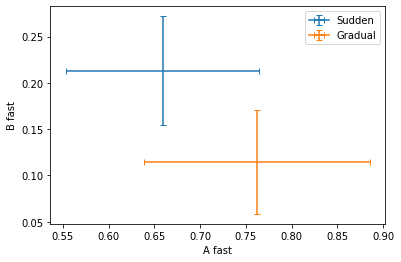

In [1368]:
plot_collapsed_across_emphasis_fits(Af, Bf, "A fast", "B fast")

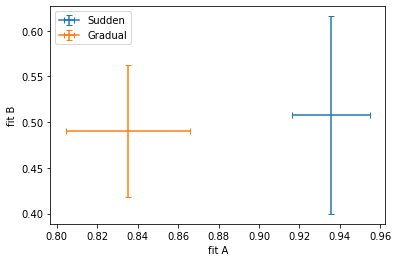

In [1020]:
plot_collapsed_across_emphasis_fits(fit_transfer_A, fit_transfer_B)

In [1380]:
def plot_collapsed_across_emphasis_fits(fit_A, fit_B, x_label, y_label):
    x = np.array([np.nanmean(fit_A[0::2, :], axis = 0), np.nanmean(fit_A[1::2, :], axis = 0)])#, np.nanmean(fit_A[2::4, :], axis = 0), np.nanmean(fit_A[3::4, :], axis = 0)])
    y = np.array([np.nanmean(fit_B[0::2, :], axis = 0), np.nanmean(fit_B[1::2, :], axis = 0)])#, np.nanmean(fit_B[2::4, :], axis = 0), np.nanmean(fit_B[3::4, :], axis = 0)])

    #x = np.array([np.nanmean(fit_A[0::2, :] - fit_A[1::2, :], axis = 0)])#, np.nanmean(fit_A[1::2, :], axis = 0)])#, np.nanmean(fit_A[2::4, :], axis = 0), np.nanmean(fit_A[3::4, :], axis = 0)])
    #y = np.array([np.nanmean(fit_B[0::2, :] - fit_B[1::2, :], axis = 0)])#, np.nanmean(fit_B[1::2, :], axis = 0)])#, np.nanmean(fit_B[2::4, :], axis = 0), np.nanmean(fit_B[3::4, :], axis = 0)])

    x_err = np.array([stat.sem(fit_A[0::2, :], axis = 0), stat.sem(fit_A[1::2, :], axis = 0)])#, stat.sem(fit_A[2::4, :], axis = 0), stat.sem(fit_A[3::4, :], axis = 0)])
    y_err = np.array([stat.sem(fit_B[0::2, :], axis = 0), stat.sem(fit_B[1::2, :], axis = 0)])#, stat.sem(fit_B[2::4, :], axis = 0), stat.sem(fit_B[3::4, :], axis = 0)])

    #x_err = np.array([stat.tstd(fit_A[0::2, :], axis = 0), stat.tstd(fit_A[1::2, :], axis = 0)])#, stat.sem(fit_A[2::4, :], axis = 0), stat.sem(fit_A[3::4, :], axis = 0)])
    #y_err = np.array([stat.tstd(fit_B[0::2, :], axis = 0), stat.tstd(fit_B[1::2, :], axis = 0)])#, stat.sem(fit_B[2::4, :], axis = 0), stat.sem(fit_B[3::4, :], axis = 0)])

    #x_conf_interval = np.array(stat.norm.interval(0.83, loc = x, scale = x_err))
    #y_conf_interval = np.array(stat.norm.interval(0.83, loc = y, scale = y_err))

    x_CI = x - np.array(stat.norm.interval(0.95, loc = x, scale = x_err))[0, :], np.array(stat.norm.interval(0.95, loc = x, scale = x_err))[1, :] - x
    y_CI = y - np.array(stat.norm.interval(0.95, loc = y, scale = y_err))[0, :], np.array(stat.norm.interval(0.95, loc = y, scale = y_err))[1, :] - y
    plot0 = plt.errorbar(x[0], y[0], xerr = [x_CI[0][0], x_CI[1][0]], yerr = [y_CI[0][0], y_CI[1][0]], capsize = 3)
    plot1 = plt.errorbar(x[1], y[1], xerr = [x_CI[0][1], x_CI[1][1]], yerr = [y_CI[0][1], y_CI[1][1]], capsize = 3)


    #plot0 = plt.errorbar(x[0], y[0], xerr = x_err[0], yerr = y_err[0], capsize = 3)
    #plot1 = plt.errorbar(x[1], y[1], xerr = x_err[1], yerr = y_err[1], capsize = 3)
    #plot0 = plt.errorbar(x[0], y[0], xerr = x_conf_interval[:, 0], yerr = y_conf_interval[:, 0], capsize = 3)
    #plot1 = plt.errorbar(x[1], y[1], xerr = x_conf_interval[:, 1], yerr = y_conf_interval[:, 1], capsize = 3)
    #plot2 = plt.errorbar(x[2], y[2], xerr = x_conf_interval[:, 2], yerr = y_conf_interval[:, 2], capsize = 3)
    #plot3 = plt.errorbar(x[3], y[3], xerr = x_conf_interval[:, 3], yerr = y_conf_interval[:, 3], capsize = 3)
    print (x[0], y[0])
    plt.legend((plot0, plot1), ('Speed', 'Accuracy'))#, 'Gradual Speed', 'Gradual Accuracy'))
    plt.xlabel(x_label)
    plt.ylabel(y_label)

[0.98785995] [0.0145074]


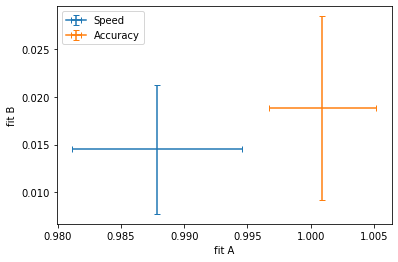

In [1346]:
plot_collapsed_across_rotation_fits(As, Bs)

[0.87887569] [0.40316036]


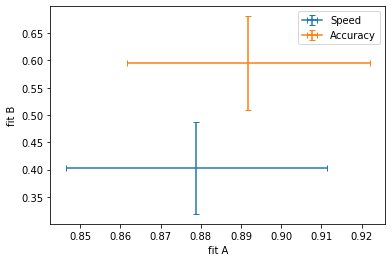

In [1021]:
plot_collapsed_across_rotation_fits(fit_transfer_A, fit_transfer_B)

In [89]:
#np.mean(np.mean(error_sum[1::4], axis = 2), axis = 0)
#stat.sem(np.mean(error_sum[1::4], axis = 2), axis = 0)
def plot_param_fits(fit_A, text):
#    quantiles = get_quantile(total_times)
    xpos = [0, 1, 2, 3, 4]
    y = np.array([np.mean(fit_A[1::4]),
                     np.mean(fit_A[0::4]), 
                     np.mean(fit_A[3::4]),
                     np.mean(fit_A[2::4])])# - np.mean(np.median(distances[1::4], axis = 2), axis = 0)[10],
    y_sem = np.array([stat.sem(fit_A[2::4]),
                             stat.sem(fit_A[2::4]),
                             stat.sem(fit_A[2::4]),
                             stat.sem(fit_A[2::4])]) 
    #print (y_sem[0])
    #y_sem = np.array([0, 0, 0, 0])
    plt.bar(0, y[0], yerr = y_sem[0], capsize = 3, fill = False)
    plt.bar(1, y[1], yerr = y_sem[1], capsize = 3, color = [0.5, 0.5, 0.5])
    plt.bar(2, y[2], yerr = y_sem[2], capsize = 3, hatch = '\\', fill = False)
    plt.bar(3, y[3], yerr = y_sem[3], capsize = 3, hatch = '\\', color = [0.5, 0.5, 0.5])

#    handles = plt.bar(range(4), y, yerr = y_sem, capsize = 3, color = ['Blue', 'Green', 'Blue', 'Green'], alpha = [1, 0.5, 0.5, 1])
    plt.xticks([0, 1, 2, 3], ['Sudden \n Accuracy', 'Sudden \n Speed', 'Gradual \n Accuracy', 'Gradual \nSpeed'], rotation = 'vertical')
    plt.ylabel('fit values')
    plt.xlabel('Condition')
    #plt.legend([handles[0], handles[1]], ['Speed', 'Accuracy'])
    plt.title(text)
    #plt.ylim(0, 45)
    print (y)
#np.shape(np.mean(error_sum[1::4], axis = 0))


In [38]:
def plot_errors_trials(num_points, first_trial, last_trial, errors, title_text):
    plt.figure(figsize=(20, 5))
    plot_0, = plt.plot(np.nanmean(np.split(np.ravel(np.nanmean(errors[0::4], axis = 0)[1:][:, first_trial:last_trial]), num_points), axis = 1), alpha = 0.5)
    plot_1, = plt.plot(np.nanmean(np.split(np.ravel(np.nanmean(errors[1::4], axis = 0)[1:][:, first_trial:last_trial]), num_points), axis = 1), alpha = 0.5)
    plot_2, = plt.plot(np.nanmean(np.split(np.ravel(np.nanmean(errors[2::4], axis = 0)[1:][:, first_trial:last_trial]), num_points), axis = 1))
    plot_3, = plt.plot(np.nanmean(np.split(np.ravel(np.nanmean(errors[3::4], axis = 0)[1:][:, first_trial:last_trial]), num_points), axis = 1))

    plt.legend((plot_0, plot_1, plot_2, plot_3), ('Sudden Speed', 'Sudden Accuracy', 'Gradual Speed', 'Gradual Accuracy'))
    plt.xlabel('Trials')
    plt.ylabel('Angular Errors')
    plt.title(title_text)

# 2-state model

In [1188]:
def dual_model_sudden(num_trials, Af, Bf, As, Bs):
    errors = np.zeros((num_trials))
    rotation = 90
    fast_est = 0
    slow_est = 0
    rotation_est = fast_est + slow_est
    for trial in range(num_trials):
        errors[trial] = rotation - rotation_est
        #print(errors[trial])
        fast_est = Af*fast_est + Bf*errors[trial]
        slow_est = As*slow_est + Bs*errors[trial]
        rotation_est = fast_est + slow_est
        #print (rotation_est)
    return errors

def dual_model_gradual(num_trials, Af, Bf, As, Bs):
    errors = np.zeros((num_trials))
    fast_est = 0
    slow_est = 0
    rotation_est = 0
    rotation = 0
    for trial in range(num_trials):
        if trial%64 == 0:
            rotation = rotation + 10
        if rotation > 90:
            rotation = 90
        errors[trial] = rotation - rotation_est
        #print(errors[trial])
        fast_est = Af*fast_est + Bf*errors[trial]
        slow_est = As*slow_est + Bs*errors[trial]
        rotation_est = fast_est + slow_est
        #print (rotation_est)
    return errors

In [1189]:
def residuals_sudden(params, num_trials, data_errors):
    model_errors = dual_model_sudden(num_trials, params[0], params[1], params[2], params[3])
    residual_error = np.sum(np.square(model_errors - data_errors))
    if params[0] > params[2]:
        residual_error = residual_error + 10000000
    if params[1] < params[3]:
        residual_error = residual_error + 10000000
    if params[0] < 0 or params[1] < 0 or params[2] < 0 or params[3] < 0:
        residual_error = residual_error + 10000000
    return residual_error

def residuals_gradual(params, num_trials, data_errors):
    model_errors = dual_model_gradual(num_trials, params[0], params[1], params[2], params[3])
    residual_error = np.sum(np.square(model_errors - data_errors))
    if params[0] > params[2]:
        residual_error = residual_error + 10000000
    if params[1] < params[3]:
        residual_error = residual_error + 10000000
    if params[0] < 0 or params[1] < 0 or params[2] < 0 or params[3] < 0:
        residual_error = residual_error + 10000000
    return residual_error

In [1230]:
def dual_model_transfer(num_trials, Af, Bf, As, Bs):
 #   A = np.exp(A)/(1 + np.exp(A))
 #   B = np.exp(B)/(1 + np.exp(B))
    
    errors = np.zeros((num_trials))
    rotation = 90
    rotation_est = 0
    fast_est = 0
    slow_est = 0

    for trial in range(num_trials):
        errors[trial] = rotation - rotation_est
        #print(errors[trial])
        fast_est = Af*fast_est + Bf*errors[trial]
        slow_est = As*slow_est + Bs*errors[trial]
        rotation_est = fast_est + slow_est
        #rotation_est = A*rotation_est + B*errors[trial]
        #print (rotation_est)
    return errors


In [1196]:
#Divide the whole thing into 16 trial blocks and fit them
def run_fits_dual(curvatures, num_trials, part_size, fit_A, fit_B):
    num_fits = int(num_trials/part_size)
    fit_As = np.zeros((60, num_fits))
    fit_Bs = np.zeros((60, num_fits))
    fit_Af = np.zeros((60, num_fits))
    fit_Bf = np.zeros((60, num_fits))
    fit_V = np.full((60, num_fits), np.inf)
    fit_success = np.zeros((60, num_fits))

    for participant in range(60):
        for fit_parts in range(num_fits):
            #starting_points = np.array([[fit_A[participant][fit_parts], fit_B[participant][fit_parts], 0.9, 0.2], [fit_A[participant][fit_parts], fit_B[participant][fit_parts], 0.99, 0.1], [fit_A[participant][fit_parts], fit_B[participant][fit_parts], 0.8, 0.3], [fit_A[participant][fit_parts], fit_B[participant][fit_parts], 0.7, 0.4], [fit_A[participant][fit_parts], fit_B[participant][fit_parts], 0.6, 0.5], [fit_A[participant][fit_parts], fit_B[participant][fit_parts], 0.5, 0.6], [fit_A[participant][fit_parts], fit_B[participant][fit_parts], 0.4, 0.7], [fit_A[participant][fit_parts], fit_B[participant][fit_parts], 0.3, 0.8], [fit_A[participant][fit_parts], fit_B[participant][fit_parts], 0.2, 0.9], [fit_A[participant][fit_parts], fit_B[participant][fit_parts], 0.1, 0.99],
            #                [0.9, 0.2, fit_A[participant][fit_parts], fit_B[participant][fit_parts]], [0.99, 0.1, fit_A[participant][fit_parts], fit_B[participant][fit_parts]], [0.8, 0.3, fit_A[participant][fit_parts], fit_B[participant][fit_parts]], [0.7, 0.4, fit_A[participant][fit_parts], fit_B[participant][fit_parts]], [0.6, 0.5, fit_A[participant][fit_parts], fit_B[participant][fit_parts]], [0.5, 0.6, fit_A[participant][fit_parts], fit_B[participant][fit_parts]], [0.4, 0.7, fit_A[participant][fit_parts], fit_B[participant][fit_parts]], [0.3, 0.8, fit_A[participant][fit_parts], fit_B[participant][fit_parts]], [0.2, 0.9, fit_A[participant][fit_parts], fit_B[participant][fit_parts]], [0.1, 0.99, fit_A[participant][fit_parts], fit_B[participant][fit_parts]]])
            #starting_points = np.array([[0.9, 0.2, 0.99, 0.02], [0.8, 0.3, 0.9, 0.03], [0.7, 0.4, 0.8, 0.04], [0.6, 0.5, 0.7, 0.05]])
            starting_points = np.array([[0.9, 0.2, 0.99, 0.02]])
            for initial_point in starting_points:
                if participant%4 == 0 or participant%4 == 1:      
                    #fits = scipy.optimize.minimize(residuals_sudden, x0 = [initial_point[0], initial_point[1], initial_point[2], initial_point[3]], args = (640, np.nan_to_num(np.ravel(curvatures[participant][1:-1]), nan = np.nanmedian(curvatures[participant][1:-1]))), method = 'Nelder-Mead')            
                    fits = scipy.optimize.basinhopping(residuals_sudden, x0 = [initial_point[0], initial_point[1], initial_point[2], initial_point[3]], minimizer_kwargs={'args': (640, np.nan_to_num(np.ravel(curvatures[participant][1:-1]), nan = np.nanmedian(curvatures[participant][1:-1]))), 'method': 'Nelder-Mead'})
                    
                    if fits.fun < fit_V[participant][fit_parts]:
                        fit_Af[participant][fit_parts] = fits.x[0]
                        fit_Bf[participant][fit_parts] = fits.x[1]
                        fit_As[participant][fit_parts] = fits.x[2]
                        fit_Bs[participant][fit_parts] = fits.x[3]
                        fit_V[participant][fit_parts] = fits.fun
                        #fit_success[participant][fit_parts] = fits.success                
                else:
                    #fits = scipy.optimize.minimize(residuals_gradual, x0 = [initial_point[0], initial_point[1], initial_point[2], initial_point[3]], args = (640, np.nan_to_num(np.ravel(curvatures[participant][1:-1]), nan = np.nanmedian(curvatures[participant][1:-1]))), method = 'Nelder-Mead')         
                    fits = scipy.optimize.basinhopping(residuals_gradual, x0 = [initial_point[0], initial_point[1], initial_point[2], initial_point[3]], minimizer_kwargs={'args': (640, np.nan_to_num(np.ravel(curvatures[participant][1:-1]), nan = np.nanmedian(curvatures[participant][1:-1]))), 'method': 'Nelder-Mead'})
                    if fits.fun < fit_V[participant][fit_parts]:
                        fit_Af[participant][fit_parts] = fits.x[0]
                        fit_Bf[participant][fit_parts] = fits.x[1]
                        fit_As[participant][fit_parts] = fits.x[2]
                        fit_Bs[participant][fit_parts] = fits.x[3]
                        fit_V[participant][fit_parts] = fits.fun
                        #fit_success[participant][fit_parts] = fits.success

        print (participant, fits.fun)
    return fit_Af, fit_Bf, fit_As, fit_Bs, fit_V, fit_success
        

In [1197]:
Af, Bf, As, Bs, fit_V_dual, fit_success_dual = run_fits_dual(curvatures_smooth, 640, 640, fit_A, fit_B)

C:\Users\Tejas\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in square
  This is separate from the ipykernel package so we can avoid doing imports until


0 61484.31207007441
1 28768.694644781302
2 27463.13335903259
3 15442.748614531138
4 22972.246158038746
5 14100.241876979162
6 6562.357279251695
7 14852.057924915862
8 30695.466355919372
9 52155.389321301685
10 28728.117707652964
11 8547.691666738207
12 51657.00459593862
13 31327.11385893414
14 37071.79058720014
15 2698.9911352168206
16 35816.95223650258
17 4666.417870295172
18 24226.08558521144
19 11405.302629544247
20 34505.84989490448
21 33481.60882285421
22 75302.55732648176
23 23459.82563467951
24 66104.76151770577
25 17006.39038912671
26 40397.64331687904
27 30271.738774991776
28 192985.68000800058
29 55491.74268428862
30 29885.969040853586
31 7477.6244321421955
32 19094.274598969925
33 29043.09441001658
34 13874.113993556832
35 5330.816910730991
36 175671.13283274922
37 115652.17476885728
38 41727.128036432085
39 5574.129589365281
40 31572.250194526612
41 17924.873386727177
42 90072.11722365019
43 6410.105892795571
44 33813.09001939304
45 54291.22333135818
46 24972.361985091073
4

# Parameter Fits

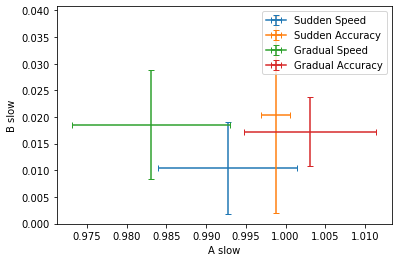

In [1384]:
plot_fits(As, Bs, "A slow", "B slow")

## Collapse Across Sudden Gradual

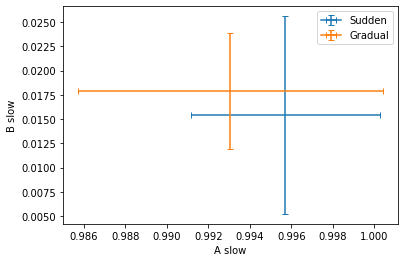

In [1386]:
plot_collapsed_across_rotation_fits(As, Bs, "A slow", "B slow")

## Collapsing across Speed/Accuracy

[0.98785995] [0.0145074]


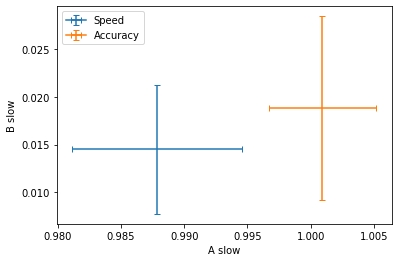

In [1387]:
plot_collapsed_across_emphasis_fits (As, Bs, "A slow", "B slow")

In [134]:
fit_V_single_state = fit_V


In [162]:
np.mean(fit_transfer_V)

8049.162100068025

61562.954918534066

In [1266]:
np.mean(fit_V)

44370.071412781646

In [1205]:
np.mean(fit_V_dual)

37585.5967655054

# % Variance accounted for

In [229]:
1 - np.sum(fit_transfer_V)/np.nansum((np.ravel(curvatures[:, 11, :]) - np.nanmean(curvatures[:, 11, :]))**2)

0.14992304958039027

In [1422]:
1 - np.sum(fit_V_dual_rts)/np.nansum((np.ravel(curvatures_smooth[:, 1:-1, :]) - np.nanmean(curvatures_smooth[:, 1:-1, :]))**2)

0.824526001972443

In [1318]:
fpe = ((1+(3/640))/(1 - (3/640)))*np.mean(fit_V_bound_raw_additive)
fpe

173075.40628043644

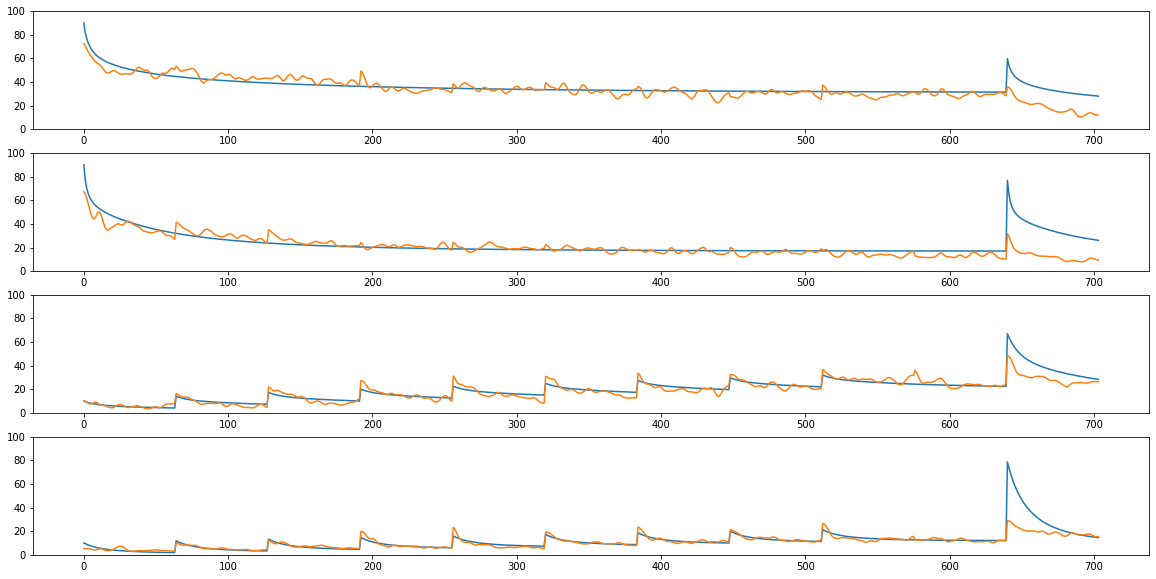

In [1333]:
plt.figure(figsize = (20, 10))
errors_predict = np.zeros((60, 704))

for participant in range(60):
    if participant % 4 == 0 or participant%4 == 1:
        errors_predict[participant][:640] = base_model_sudden(640, fit_A[participant], fit_B[participant])
#num_trials, Af, Bf, As, Bs
#        errors_predict[participant][:640] = dual_model_sudden(640, Af[participant], Bf[participant], As[participant], Bs[participant])

    else:    
#        errors_predict[participant][:640] = dual_model_gradual(640, Af[participant], Bf[participant], As[participant], Bs[participant])
        errors_predict[participant][:640] = base_model_gradual(640, fit_A[participant], fit_B[participant])

#    errors_predict[participant][640:] = dual_model_transfer(64, Af[participant], Bf[participant], As[participant], Bs[participant])
    errors_predict[participant][640:] = base_model_transfer(64, fit_A[participant], fit_B[participant], np.nanmean(curvatures[participant][10][-16:]))

for participant in range(4):
    if participant % 4 == 0 or participant%4 == 1:
        plt.subplot(4, 1, participant + 1 )
        y_err = np.array(stat.norm.interval(0.95, loc = y, scale = y_err))
        y_err = np.m
        plt.plot(np.mean(errors_predict[participant::4], axis = 0))
        plt.plot(np.ravel(np.mean(curvatures_smooth[participant::4], axis = 0)[1:]))
    else:
        plt.subplot(4, 1, participant + 1 )
        plt.plot(np.mean(errors_predict[participant::4], axis = 0))
        plt.plot(np.ravel(np.mean(curvatures_smooth[participant::4], axis = 0)[1:]))
    plt.ylim((0, 100))


In [243]:
import pandas as pd

In [1434]:
df_A = pd.DataFrame({"Emphasis": np.tile(["Speed", "Accuracy"], 30),
                   "Rotation": np.tile(["Sudden", "Sudden", "Gradual", "Gradual"], 15),
                   "fit_A": Af[:, 0]})

model_A = ols('fit_A ~ C(Emphasis)*C(Rotation)', data = df_A).fit()

aov_table_A = sm.stats.anova_lm(model_A)


df_B = pd.DataFrame({"Emphasis": np.tile(["Speed", "Accuracy"], 30),
                   "Rotation": np.tile(["Sudden", "Sudden", "Gradual", "Gradual"], 15),
                   "fit_B": Bf[:, 0]})

model_B = ols('fit_B ~ C(Emphasis)*C(Rotation)', data = df_B).fit()
aov_table_B = sm.stats.anova_lm(model_B)


In [1435]:
aov_table_B

,df,sum_sq,mean_sq,F,PR(>F)
C(Emphasis),1.0,0.134141,0.134141,5.685327,0.020520
C(Rotation),1.0,0.146227,0.146227,6.197585,0.015789
C(Emphasis):C(Rotation),1.0,0.038939,0.038939,1.650372,0.204197
Residual,56.0,1.321274,0.023594,NaN,NaN


In [1402]:
aov_table_A

,df,sum_sq,mean_sq,F,PR(>F)
C(Emphasis),1.0,0.002562,0.002562,10.581659,0.001938
C(Rotation),1.0,0.000105,0.000105,0.435239,0.512134
C(Emphasis):C(Rotation),1.0,0.000743,0.000743,3.069224,0.085262
Residual,56.0,0.013558,0.000242,NaN,NaN


Effect of emphasis on As

Effect of rotation and emphasis on Bf

# State Space model for RT data

In [1302]:
num_trials = 640
def base_model_sudden(num_trials, RT, A, B, m):
 #   A = np.exp(A)/(1 + np.exp(A))
 #   B = np.exp(B)/(1 + np.exp(B))
    
    errors = np.zeros((num_trials))
    rotation = 90
    rotation_est = 0
    for trial in range(num_trials - 1):
        errors[trial] = rotation - rotation_est
        #print(errors[trial])
        rotation_est = A*rotation_est + B*(1 - np.exp(-m*RT[trial+1]))*errors[trial]# + m*RT[trial+1]
#        rotation_est = A*rotation_est + B*errors[trial] + m*RT[trial+1]
 
    #print (rotation_est)
    errors[trial+1] = rotation - rotation_est
    
    return errors

def base_model_gradual(num_trials, RT, A, B, m):
#    A = np.exp(A)/(1 + np.exp(A))
#    B = np.exp(B)/(1 + np.exp(B))
    
    errors = np.zeros((num_trials))
    rotation_est = 0
    rotation = 0
    for trial in range(num_trials - 1):
        if trial%64 == 0:
            rotation = rotation + 10
        if rotation > 90:
            rotation = 90
        errors[trial] = rotation - rotation_est
        #print(errors[trial])
        rotation_est = A*rotation_est + B*(1 - np.exp(-m*RT[trial+1]))*errors[trial]# + m*RT[trial+1]
#        rotation_est = A*rotation_est + B*errors[trial] + m*RT[trial+1]

        #print (rotation_est)
    errors[trial+1] = rotation - rotation_est

    return errors

def residuals_base_sudden(params, num_trials, data_errors, RTs):
#   model_errors = base_model_sudden(num_trials, params[0], params[1])
    model_errors = base_model_sudden(num_trials, RTs, params[0], params[1], params[2])
    residual_error = np.sum(np.square(model_errors - data_errors))
    #if params[0] > params[2]:
    #    residual_error = residual_error + 1000000
    #if params[1] < params[3]:
    #    residual_error = residual_error + 1000000
    if params[0] < 0 or params[1] < 0 or params[2] < 0:# or params[3] < 0:
        residual_error = residual_error + 1000000
    if params[0] > 1 or params[1] > 1 or params[2] > 1:# or params[3] < 0:
        residual_error = residual_error + 1000000

    return residual_error

def residuals_base_gradual(params, num_trials, data_errors, RTs):
#   model_errors = base_model_sudden(num_trials, params[0], params[1])
    model_errors = base_model_gradual(num_trials, RTs, params[0], params[1], params[2])
    residual_error = np.sum(np.square(model_errors - data_errors))
    #if params[0] > params[2]:
    #    residual_error = residual_error + 1000000
    #if params[1] < params[3]:
    #    residual_error = residual_error + 1000000
    if params[0] < 0 or params[1] < 0 or params[2] < 0:# or params[3] < 0:
        residual_error = residual_error + 1000000
    if params[0] > 1 or params[1] > 1 or params[2] > 1:# or params[3] < 0:
        residual_error = residual_error + 1000000

    return residual_error

In [1076]:
scipy.optimize.basinhopping(residuals_base_sudden, x0=[0.1, 0.1, 0.1], minimizer_kwargs={'args': (640, np.ravel(curvatures[1][1:-1]), np.ravel(its[1][1:-1])), 'method': 'Nelder-Mead'}, stepsize=0.5)

C:\Users\Tejas\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in double_scalars
  if sys.path[0] == '':
C:\Users\Tejas\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':
C:\Users\Tejas\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: overflow encountered in square
C:\Users\Tejas\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Tejas\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:597: RuntimeWarning: invalid value encountered in subtract
  numpy.max(numpy.abs(fsim[0] - fsim[1:])) <= fatol):


                        fun: 149691.22282237012
 lowest_optimization_result:  final_simplex: (array([[0.99844346, 1.        , 0.00763147],
       [0.99844351, 0.99999977, 0.00763136],
       [0.99844355, 0.99999994, 0.0076313 ],
       [0.9984435 , 0.99999926, 0.00763139]]), array([149691.22282237, 149691.22287292, 149691.22289002, 149691.22292078]))
           fun: 149691.22282237012
       message: 'Optimization terminated successfully.'
          nfev: 547
           nit: 306
        status: 0
       success: True
             x: array([0.99844346, 1.        , 0.00763147])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 65
                       nfev: 52312
                        nit: 100
                          x: array([0.99844346, 1.        , 0.00763147])

# Read RT Data

In [1303]:
def times(data, block):
    initial_time = scipy.io.loadmat('data/data{data}/initial_time/initial_time{block}.mat'.format(block=str(block), data=str(data)))
    movement_time = scipy.io.loadmat('data/data{data}/movement_time/movement_time{block}.mat'.format(block = str(block), data=str(data)))
    #squares = scipy.io.loadmat('data/participants/data{data}/squares/coordinates/squares{block}.mat'.format(block=str(block), data=str(data)))
    #xdiff = (ideal_traj['idealXs'] - traj['x'])
    #ydiff = (ideal_traj['idealYs'] - traj['y'])
    initial_time = initial_time['initial_time'][:, 0]
    movement_time = movement_time['movement_time'][:, 0]
    return initial_time, movement_time
def get_times():
    initial_times = np.zeros((60, 12, 64))
    movement_times = np.zeros((60, 12, 64))
    for participant in range(60):
        for block in range(12):
            it, mt = times(participant+1000, block)
            initial_times[participant, block] = it
            movement_times[participant, block] = mt
    return initial_times, movement_times
its, mts = get_times()

In [1304]:
#Divide the whole thing into 16 trial blocks and fit them
def run_fits(curvatures, RTs, num_trials, part_size, first):
    num_parts = int((num_trials-first)/part_size)
    fit_A = np.zeros((60, num_parts))
    fit_B = np.zeros((60, num_parts))
    fit_m = np.zeros((60, num_parts))
    fit_bias = np.zeros((60, num_parts))
    fit_V = np.full((60, num_parts), np.inf)
    fit_success = np.zeros((60, num_parts))
    fit_num = 0
    #starting_points = np.array([[0.5, 0.6], [0.4, 0.7], [0.3, 0.8], [0.2, 0.9], [0.1, 0.99], [0.9, 0.2], [0.99, 0.1], [0.8, 0.3], [0.7, 0.4], [0.6, 0.5]])
    
    #A = np.log(params[0]/(1-params[0]))
    #B = np.log(params[1]/(1-params[1]))

#    starting_points = np.array([[np.log(0.999/(1 - 0.999)), np.log(0.002/(1 - 0.002))]])
    starting_points = np.array([[0.999, 0.002, 0.1]])

    for curr_trial in range(first, num_trials, part_size):
        for participant in range(60):
            for initial_point in starting_points:
                if participant%4 == 0 or participant%4 == 1:
                #print (np.nan_to_num(np.ravel(curvatures[participant])[first:first+part_size], nan = np.nanmedian(np.ravel(curvatures[participant])[first:first+part_size])))
                #popt, pcov = curve_fit(base_model_sudden, part_size, np.nan_to_num(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size], nan = np.nanmedian(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size])), bounds=((0, 0), (1, np.inf)))
                    #fits = scipy.optimize.minimize(residuals_base_sudden, x0 = [initial_point[0], initial_point[1]], args = (part_size, np.nan_to_num(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size], nan = np.nanmedian(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size]))), method = 'Nelder-Mead')
                    fits = scipy.optimize.basinhopping(residuals_base_sudden, x0 = [initial_point[0], initial_point[1], initial_point[2]], minimizer_kwargs={'args': (part_size, np.nan_to_num(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size], nan = np.nanmedian(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size])), np.nan_to_num(np.ravel(RTs[participant])[curr_trial:curr_trial+part_size], nan = np.nanmedian(np.ravel(RTs[participant])[curr_trial:curr_trial+part_size]))), 'method': 'Nelder-Mead'}, stepsize=0.05)
                    
                    if fits.fun < fit_V[participant][fit_num]:
                        fit_A[participant][fit_num] = fits.x[0]
                        fit_B[participant][fit_num] = fits.x[1]
                        fit_m[participant][fit_num] = fits.x[2]
                        #fit_bias[participant][fit_num] = fits.x[2]
                        fit_V[participant][fit_num] = fits.fun
                        #fit_success[participant][fit_num] = fits.success   
                    print (fits.fun)
                else:
                    #popt, pcov = curve_fit(base_model_gradual, part_size, np.nan_to_num(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size], nan = np.nanmedian(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size])), bounds=((0, 0), (1, np.inf)))
                    #fits = scipy.optimize.minimize(residuals_base_gradual, x0 = [initial_point[0], initial_point[1]], args = (part_size, np.nan_to_num(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size], nan = np.nanmedian(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size]))), method = 'Nelder-Mead')
                    fits = scipy.optimize.basinhopping(residuals_base_gradual, x0 = [initial_point[0], initial_point[1], initial_point[2]], minimizer_kwargs={'args': (part_size, np.nan_to_num(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size], nan = np.nanmedian(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size])), np.nan_to_num(np.ravel(its[participant])[curr_trial:curr_trial+part_size], nan = np.nanmedian(np.ravel(RTs[participant])[curr_trial:curr_trial+part_size]))), 'method': 'Nelder-Mead'}, stepsize = 0.05)
                    
                    if fits.fun < fit_V[participant][fit_num]:
                        fit_A[participant][fit_num] = fits.x[0]
                        fit_B[participant][fit_num] = fits.x[1]
                        fit_m[participant][fit_num] = fits.x[2]
                        #fit_bias[participant][fit_num] = fits.x[2]
                        fit_V[participant][fit_num] = fits.fun
                        #fit_success[participant][fit_num] = fits.success
                    print (participant, fits.fun)

        fit_num = fit_num + 1
    return fit_A, fit_B, fit_m, fit_V
        

In [1078]:
fit_A, fit_B, fit_m, fit_V = run_fits(curvatures_smooth, its, 704, 640, 64)

73084.2562164568
41385.02307103401


C:\Users\Tejas\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: overflow encountered in square


2 29083.159083770457


C:\Users\Tejas\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in double_scalars


3 16118.837872351158
30538.000274869097
19557.300323573756
6 7162.663771211834
7 15698.171441864211
58437.19884830325
72325.93998511901
10 29013.455965402572
11 9663.924076137588
51025.04584334252
61146.26630527824
14 37607.25622185263
15 3823.7398953154743
47881.34373083387
1006747.3873056432
18 24979.33126022096
19 11941.199008060254
61346.42381847104
43727.48448561174
22 75475.13053745002
23 25390.04452183286
71756.46965518364


C:\Users\Tejas\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: overflow encountered in square
C:\Users\Tejas\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in double_scalars
  if sys.path[0] == '':
C:\Users\Tejas\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':
C:\Users\Tejas\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in exp
  if sys.path[0] == '':


26826.36155989761
26 41033.13455620364
27 35885.90558999058
196579.39702343792
61448.16736458981
30 35192.631293892235
31 8680.651040701843
34910.68474088441
43663.96305463285
34 14563.969353074928
35 6713.603370884623
188691.532168561
139394.62439498163
38 43074.874234719406
39 5724.079247272004
43035.051284081186
39080.30406381977
42 84611.61422119517
43 6115.443408124465
35237.32709126566
84453.68721782541
46 25969.395133024354
47 13131.361407996916
116577.88042599976
60770.96466117428
50 31920.282429931867
51 16112.342822534414
88150.41100366821
66942.11120214192
54 48964.20101068852
55 20097.9937156889
55516.43384109538
15223.926848059815
58 23998.60092746016
59 10569.329883353443


In [1305]:
def plot_data_vs_fits(its, fit_A, fit_B, fit_m):
    plt.figure(figsize = (20, 10))
    errors_predict = np.zeros((60, 704))

    for participant in range(60):
        if participant % 4 == 0 or participant%4 == 1:
            errors_predict[participant][:640] = base_model_sudden(640,np.ravel(its[participant][1:-1]), fit_A_unbound_smooth_additive[participant], fit_B_unbound_smooth_additive[participant], fit_m_unbound_smooth_additive[participant])

        else:    
            errors_predict[participant][:640] = base_model_gradual(640, np.ravel(its[participant][1:-1]), fit_A_unbound_smooth_additive[participant], fit_B_unbound_smooth_additive[participant], fit_m_unbound_smooth_additive[participant])

        #errors_predict[participant][640:] = base_model_transfer(64, fit_A[participant], fit_B[participant])

    for participant in range(4):
        if participant % 4 == 0 or participant%4 == 1:
            plt.subplot(4, 1, participant + 1 )
            plt.plot(np.mean(errors_predict[participant::4], axis = 0))
            plt.plot(np.ravel(np.mean(curvatures_smooth[participant::4], axis = 0)[1:]))
        else:
            plt.subplot(4, 1, participant + 1 )
            plt.plot(np.mean(errors_predict[participant::4], axis = 0))
            plt.plot(np.ravel(np.mean(curvatures_smooth[participant::4], axis = 0)[1:]))
        plt.ylim((0, 100))


C:\Users\Tejas\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in multiply
  if sys.path[0] == '':
C:\Users\Tejas\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in multiply


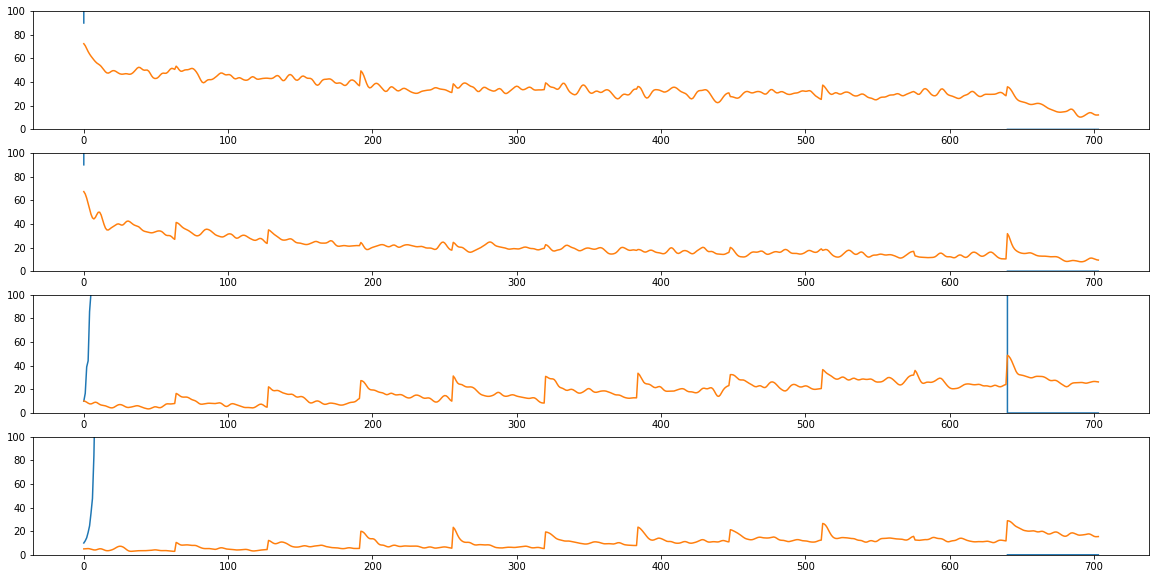

In [1306]:
plot_data_vs_fits(its, fit_A_bound_smooth_multiplicative, fit_B_bound_smooth_multiplicative, fit_m_bound_smooth_multiplicative)

In [1290]:
def plot_fits(fit_A, fit_B, x_label, y_label):
    x = np.array([np.nanmean(fit_A[0::4, :], axis = 0), np.nanmean(fit_A[1::4, :], axis = 0), np.nanmean(fit_A[2::4, :], axis = 0), np.nanmean(fit_A[3::4, :], axis = 0)])
    y = np.array([np.nanmean(fit_B[0::4, :], axis = 0), np.nanmean(fit_B[1::4, :], axis = 0), np.nanmean(fit_B[2::4, :], axis = 0), np.nanmean(fit_B[3::4, :], axis = 0)])
    x_err = np.array([stat.sem(fit_A[0::4, :], axis = 0), stat.sem(fit_A[1::4, :], axis = 0), stat.sem(fit_A[2::4, :], axis = 0), stat.sem(fit_A[3::4, :], axis = 0)])
    y_err = np.array([stat.sem(fit_B[0::4, :], axis = 0), stat.sem(fit_B[1::4, :], axis = 0), stat.sem(fit_B[2::4, :], axis = 0), stat.sem(fit_B[3::4, :], axis = 0)])
    #x_err = np.array([stat.tstd(fit_A[0::4, :], axis = 0), stat.tstd(fit_A[1::4, :], axis = 0), stat.tstd(fit_A[2::4, :], axis = 0), stat.tstd(fit_A[3::4, :], axis = 0)])
    #y_err = np.array([stat.tstd(fit_B[0::4, :], axis = 0), stat.tstd(fit_B[1::4, :], axis = 0), stat.tstd(fit_B[2::4, :], axis = 0), stat.tstd(fit_B[3::4, :], axis = 0)])

    #x_conf_interval = np.array(stat.norm.interval(0.83, loc = x, scale = x_err))
    #y_conf_interval = np.array(stat.norm.interval(0.83, loc = y, scale = y_err))
    x_CI = x - np.array(stat.norm.interval(0.95, loc = x, scale = x_err))[0, :], np.array(stat.norm.interval(0.95, loc = x, scale = x_err))[1, :] - x
    y_CI = y - np.array(stat.norm.interval(0.95, loc = y, scale = y_err))[0, :], np.array(stat.norm.interval(0.95, loc = y, scale = y_err))[1, :] - y


    #print (x_conf_interval[:, 0])
    #plt.errorbar(x, y, xerr = x_err, yerr = y_err, linestyle = 'None', capsize = 3)
    plot0 = plt.errorbar(x[0], y[0], xerr = [x_CI[0][0], x_CI[1][0]], yerr = [y_CI[0][0], y_CI[1][0]], capsize = 3)
    plot1 = plt.errorbar(x[1], y[1], xerr = [x_CI[0][1], x_CI[1][1]], yerr = [y_CI[0][1], y_CI[1][1]], capsize = 3)
    plot2 = plt.errorbar(x[2], y[2], xerr = [x_CI[0][2], x_CI[1][2]], yerr = [y_CI[0][2], y_CI[1][2]], capsize = 3)
    plot3 = plt.errorbar(x[3], y[3], xerr = [x_CI[0][3], x_CI[1][3]], yerr = [y_CI[0][3], y_CI[1][3]], capsize = 3)

    #plot0 = plt.scatter(fit_A[0::4], fit_B[0::4])
    #plot1 = plt.scatter(fit_A[1::4], fit_B[1::4])
    #plot2 = plt.scatter(fit_A[2::4], fit_B[2::4])
    #plot3 = plt.scatter(fit_A[3::4], fit_B[3::4])

    plt.legend((plot0, plot1, plot2, plot3), ('Sudden Speed', 'Sudden Accuracy', 'Gradual Speed', 'Gradual Accuracy'))
    plt.xlabel(x_label)
    plt.ylabel(y_label)

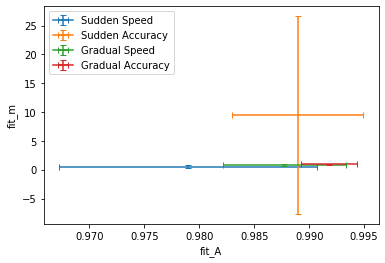

In [1308]:
#plot_fits(np.reshape(np.mean(np.nanmedian(its, axis = 2), axis = 1), (60, 1)), fit_m, "Mean ITs", "fit_m")
plot_fits(fit_A_bound_smooth_multiplicative, fit_mb, "fit_A", "fit_m")

## Adding RT to dual state model

In [1418]:
def dual_model_sudden_rts(num_trials, rts, Af, Bf, As, Bs, m):
    errors = np.zeros((num_trials))
    rotation = 90
    fast_est = 0
    slow_est = 0
    rotation_est = fast_est + slow_est
    for trial in range(num_trials - 1):
        errors[trial] = rotation - rotation_est
        #print(errors[trial])
        fast_est = Af*fast_est + Bf*errors[trial]
        slow_est = As*slow_est + Bs*errors[trial]
        rotation_est = fast_est + slow_est + m*rts[trial+1]
        #print (rotation_est)
    errors[trial+1] = rotation - rotation_est
    return errors

def dual_model_gradual_rts(num_trials, rts, Af, Bf, As, Bs, m):
    errors = np.zeros((num_trials))
    fast_est = 0
    slow_est = 0
    rotation_est = 0
    rotation = 0
    for trial in range(num_trials-1):
        if trial%64 == 0:
            rotation = rotation + 10
        if rotation > 90:
            rotation = 90
        errors[trial] = rotation - rotation_est
        #print(errors[trial])
        fast_est = Af*fast_est + Bf*errors[trial]
        slow_est = As*slow_est + Bs*errors[trial]
        rotation_est = fast_est + slow_est + m*rts[trial+1]
        #print (rotation_est)
    errors[trial+1] = rotation - rotation_est
    return errors


In [1419]:
def residuals_sudden_rts(params, num_trials, data_errors, rts):
    model_errors = dual_model_sudden_rts(num_trials, rts, params[0], params[1], params[2], params[3], params[4])
    residual_error = np.sum(np.square(model_errors - data_errors))
    if params[0] > params[2]:
        residual_error = residual_error + 10000000
    if params[1] < params[3]:
        residual_error = residual_error + 10000000
    if params[0] < 0 or params[1] < 0 or params[2] < 0 or params[3] < 0:
        residual_error = residual_error + 10000000
    return residual_error

def residuals_gradual_rts(params, num_trials, data_errors, rts):
    model_errors = dual_model_gradual_rts(num_trials, rts, params[0], params[1], params[2], params[3], params[4])
    residual_error = np.sum(np.square(model_errors - data_errors))
    if params[0] > params[2]:
        residual_error = residual_error + 10000000
    if params[1] < params[3]:
        residual_error = residual_error + 10000000
    if params[0] < 0 or params[1] < 0 or params[2] < 0 or params[3] < 0:
        residual_error = residual_error + 10000000
    return residual_error

In [1439]:
#Divide the whole thing into 16 trial blocks and fit them
def run_fits_dual_rts(curvatures, rts, num_trials, part_size, fit_A, fit_B):
    num_fits = int(num_trials/part_size)
    fit_As = np.zeros((60, num_fits))
    fit_Bs = np.zeros((60, num_fits))
    fit_Af = np.zeros((60, num_fits))
    fit_Bf = np.zeros((60, num_fits))
    fit_V = np.full((60, num_fits), np.inf)
    fit_m = np.zeros((60, num_fits))
    fit_success = np.zeros((60, num_fits))

    for participant in range(60):
        for fit_parts in range(num_fits):
            #starting_points = np.array([[fit_A[participant][fit_parts], fit_B[participant][fit_parts], 0.9, 0.2], [fit_A[participant][fit_parts], fit_B[participant][fit_parts], 0.99, 0.1], [fit_A[participant][fit_parts], fit_B[participant][fit_parts], 0.8, 0.3], [fit_A[participant][fit_parts], fit_B[participant][fit_parts], 0.7, 0.4], [fit_A[participant][fit_parts], fit_B[participant][fit_parts], 0.6, 0.5], [fit_A[participant][fit_parts], fit_B[participant][fit_parts], 0.5, 0.6], [fit_A[participant][fit_parts], fit_B[participant][fit_parts], 0.4, 0.7], [fit_A[participant][fit_parts], fit_B[participant][fit_parts], 0.3, 0.8], [fit_A[participant][fit_parts], fit_B[participant][fit_parts], 0.2, 0.9], [fit_A[participant][fit_parts], fit_B[participant][fit_parts], 0.1, 0.99],
            #                [0.9, 0.2, fit_A[participant][fit_parts], fit_B[participant][fit_parts]], [0.99, 0.1, fit_A[participant][fit_parts], fit_B[participant][fit_parts]], [0.8, 0.3, fit_A[participant][fit_parts], fit_B[participant][fit_parts]], [0.7, 0.4, fit_A[participant][fit_parts], fit_B[participant][fit_parts]], [0.6, 0.5, fit_A[participant][fit_parts], fit_B[participant][fit_parts]], [0.5, 0.6, fit_A[participant][fit_parts], fit_B[participant][fit_parts]], [0.4, 0.7, fit_A[participant][fit_parts], fit_B[participant][fit_parts]], [0.3, 0.8, fit_A[participant][fit_parts], fit_B[participant][fit_parts]], [0.2, 0.9, fit_A[participant][fit_parts], fit_B[participant][fit_parts]], [0.1, 0.99, fit_A[participant][fit_parts], fit_B[participant][fit_parts]]])
            #starting_points = np.array([[0.9, 0.2, 0.99, 0.02], [0.8, 0.3, 0.9, 0.03], [0.7, 0.4, 0.8, 0.04], [0.6, 0.5, 0.7, 0.05]])
            starting_points = np.array([[0.9, 0.2, 0.99, 0.02, 0.1]])
            for initial_point in starting_points:
                if participant%4 == 0 or participant%4 == 1:      
                    #fits = scipy.optimize.minimize(residuals_sudden, x0 = [initial_point[0], initial_point[1], initial_point[2], initial_point[3]], args = (640, np.nan_to_num(np.ravel(curvatures[participant][1:-1]), nan = np.nanmedian(curvatures[participant][1:-1]))), method = 'Nelder-Mead')            
                    fits = scipy.optimize.basinhopping(residuals_sudden_rts, x0 = [initial_point[0], initial_point[1], initial_point[2], initial_point[3], initial_point[4]], minimizer_kwargs={'args': (640, np.nan_to_num(np.ravel(curvatures[participant][1:-1]), nan = np.nanmedian(curvatures[participant][1:-1])), np.ravel(rts[participant][1:-1])), 'method': 'Nelder-Mead'})
                    
                    if fits.fun < fit_V[participant][fit_parts]:
                        fit_Af[participant][fit_parts] = fits.x[0]
                        fit_Bf[participant][fit_parts] = fits.x[1]
                        fit_As[participant][fit_parts] = fits.x[2]
                        fit_Bs[participant][fit_parts] = fits.x[3]
                        fit_m[participant][fit_parts] = fits.x[4]
                        fit_V[participant][fit_parts] = fits.fun
                        #fit_success[participant][fit_parts] = fits.success                
                else:
                    #fits = scipy.optimize.minimize(residuals_gradual, x0 = [initial_point[0], initial_point[1], initial_point[2], initial_point[3]], args = (640, np.nan_to_num(np.ravel(curvatures[participant][1:-1]), nan = np.nanmedian(curvatures[participant][1:-1]))), method = 'Nelder-Mead')         
                    fits = scipy.optimize.basinhopping(residuals_gradual_rts, x0 = [initial_point[0], initial_point[1], initial_point[2], initial_point[3], initial_point[4]], minimizer_kwargs={'args': (640, np.nan_to_num(np.ravel(curvatures[participant][1:-1]), nan = np.nanmedian(curvatures[participant][1:-1])), np.ravel(rts[participant][1:-1])), 'method': 'Nelder-Mead'})
                    if fits.fun < fit_V[participant][fit_parts]:
                        fit_Af[participant][fit_parts] = fits.x[0]
                        fit_Bf[participant][fit_parts] = fits.x[1]
                        fit_As[participant][fit_parts] = fits.x[2]
                        fit_Bs[participant][fit_parts] = fits.x[3]
                        fit_m[participant][fit_parts] = fits.x[4]
                        fit_V[participant][fit_parts] = fits.fun
                        #fit_success[participant][fit_parts] = fits.success

        print (participant, fits.fun)
    return fit_Af, fit_Bf, fit_As, fit_Bs, fit_m, fit_V, fit_success
        

In [1440]:
Af_rts, Bf_rts, As_rts, Bs_rts, m_rts, fit_V_dual_rts, fit_success_dual_rts = run_fits_dual_rts(curvatures_smooth, its, 640, 640, fit_A, fit_B)

C:\Users\Tejas\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in square
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Tejas\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:597: RuntimeWarning: invalid value encountered in subtract
  numpy.max(numpy.abs(fsim[0] - fsim[1:])) <= fatol):


0 60101.16713775586


C:\Users\Tejas\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


1 28492.47287228045


C:\Users\Tejas\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in square
  


2 26562.884875103326
3 15357.120255823917
4 22765.60661455324
5 13830.303176061465
6 6500.164170428884
7 14766.289000959165
8 30273.5706032731
9 51121.63856662554
10 28723.528540280975
11 8546.15521261914
12 51044.35173127553
13 31150.160564323214
14 36705.99339556173
15 2695.110885851627
16 35727.61500415551
17 4666.247983269219
18 23255.82024157039
19 11380.184368668673
20 34370.103387597046
21 33004.0717762647
22 73274.92049820666
23 22288.978439971645
24 65766.51001519524
25 16754.813002621464
26 36332.311974953096
27 26132.14418162084
28 191189.89820324216
29 53533.091921774976
30 29438.253955711014
31 7394.790744828155
32 18413.889929523466
33 28099.36898486953
34 13850.100770437615
35 5324.303266030445
36 169966.9630037552
37 107612.66733055667
38 40053.56162870704
39 5535.019363124424
40 31105.389284502544
41 17832.86992831358
42 88175.07552359784
43 6119.464753267142
44 32359.19360289553
45 54281.59448798602
46 24832.7427238171
47 12180.17634753754
48 101154.6978066203
49 4458

In [1445]:
df_A = pd.DataFrame({"Emphasis": np.tile(["Speed", "Accuracy"], 30),
                   "Rotation": np.tile(["Sudden", "Sudden", "Gradual", "Gradual"], 15),
                   "fit_A": Af_rts[:, 0]})

model_A = ols('fit_A ~ C(Emphasis)*C(Rotation)', data = df_A).fit()

aov_table_A = sm.stats.anova_lm(model_A)


df_B = pd.DataFrame({"Emphasis": np.tile(["Speed", "Accuracy"], 30),
                   "Rotation": np.tile(["Sudden", "Sudden", "Gradual", "Gradual"], 15),
                   "fit_B": Bf_rts[:, 0]})

model_B = ols('fit_B ~ C(Emphasis)*C(Rotation)', data = df_B).fit()
aov_table_B = sm.stats.anova_lm(model_B)


In [1446]:
aov_table_B

,df,sum_sq,mean_sq,F,PR(>F)
C(Emphasis),1.0,0.120799,0.120799,5.475723,0.022872
C(Rotation),1.0,0.143691,0.143691,6.513380,0.013462
C(Emphasis):C(Rotation),1.0,0.026320,0.026320,1.193058,0.279390
Residual,56.0,1.235409,0.022061,NaN,NaN


In [198]:
fit_V_unbound = fit_V
fit_A_unbound = fit_A
fit_B_unbound = fit_B
fit_m_unbound = fit_m


In [1082]:
fit_V_bound_smooth_multiplicative = fit_V
fit_A_bound_smooth_multiplicative = fit_A
fit_B_bound_smooth_multiplicative = fit_B
fit_m_bound_smooth_multiplicative = fit_m


In [1054]:
fit_V_bound_raw_multiplicative = fit_V
fit_A_bound_raw_multiplicative = fit_A
fit_B_bound_raw_multiplicative= fit_B
fit_m_bound_raw_multiplicative = fit_m
#fit_bias_bound_smooth = fit_bias


In [1065]:
fit_V_bound_raw_additive = fit_V
fit_A_bound_raw_additive = fit_A
fit_B_bound_raw_additive = fit_B
fit_m_bound_raw_additive = fit_m

In [1073]:
fit_V_unbound_smooth_additive = fit_V
fit_A_unbound_smooth_additive = fit_A
fit_B_unbound_smooth_additive = fit_B
fit_m_unbound_smooth_additive = fit_m

# Direction-Wise analysis

In [484]:
def get_targets():
    targets = np.zeros((60, 12, 64))
    for data in range(1000, 1060):
        for block in range(12):
            target_load = scipy.io.loadmat('data/data{data}/squares/squares{block}.mat'.format(block=str(block), data=str(data)))
            targets[data-1000][block][:]= target_load['squares'][0]
    return targets

In [487]:
targets = get_targets()

In [699]:
def target_specific_measures(targets, measure):
    target_measure = np.zeros((60, 12, 4, 16))
    for participant in range(60):
        for block in range(12):
            for target_loc in range(4):
                target_measure[participant][block][target_loc] = measure[participant][block][np.where(targets[participant][block] == np.unique(targets[participant][block])[target_loc])]
    return target_measure

In [948]:
target_curvatures = target_specific_measures(targets, curvatures)
target_its = target_specific_measures(targets, its)
target_mts = target_specific_measures(targets, mts)

In [950]:
def difference_in_directions(condition, direction_considered, target_measure, title_text, y_label):
    permutation = list()
    permutation.append(direction_considered)
        
    for i in range(4):
        if i == direction_considered:
            continue
        else:
            permutation.append(i)
    print (permutation)
    idx = np.empty_like(permutation)
    idx[permutation] = np.arange(len(permutation))

    plot0, = plt.plot(np.ravel(np.nanmean(target_measure[condition::4, :, direction_considered, :], axis = 0)))
    rearanged_measure = target_measure[:, :, idx, :]
    plot1, = plt.plot(np.ravel(np.nanmean(np.mean(rearanged_measure[condition::4, :, 1:, :], axis = 0), axis = 1)))
    plt.legend((plot0, plot1), ('Direction Considered', 'Mean of other directions'))
    plt.title(title_text)
    plt.xlabel('trials')
    plt.ylabel(y_label)


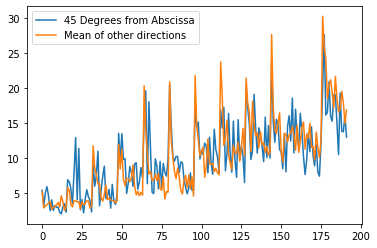

In [951]:
plot0, = plt.plot(np.ravel(np.mean(target_curvatures[3::4, :, 0, :], axis = 0)))
plot1, = plt.plot(np.ravel(np.mean(np.mean(target_curvatures[3::4, :, 1:, :], axis = 0), axis = 1)))
plt.legend((plot0, plot1), ('45 Degrees from Abscissa', 'Mean of other directions'))

[3, 0, 1, 2]


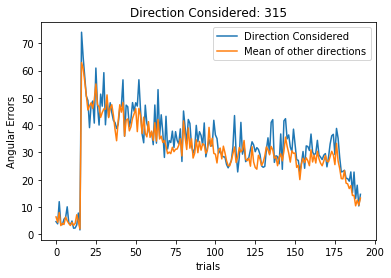

In [961]:
difference_in_directions(condition = 0, direction_considered=3, target_measure=target_curvatures, title_text='Direction Considered: 315', y_label='Angular Errors')

In [657]:
permutation = [1, 0, 2, 3]
idx = np.empty_like(permutation)
idx[permutation] = np.arange(len(permutation))


In [750]:
np.mean(target_mts[2::4, :, 0, :])

1.3517242999910697

In [749]:
np.mean(target_mts[2::4, :, 2, :])

1.2207978262288133

# Calculating Speed

In [1084]:
def get_dist():
    distances = np.zeros((60, 12, 64))
    for data in range(60):
        for block in range(12):
            traj = scipy.io.loadmat('data/data{data}/actual_trajectories/trajectories{block}.mat'.format(block=str(block), data=str(data+1000)))
            for trial in range(64):
                trajx, trajy = traj['x'][0][trial][0], traj['y'][0][trial][0]
                distance_covered = 0
                for i in range(len(trajx[:-1])):
                    #print (trajx[i], trajy[i])
                    distance_covered = distance_covered + np.sqrt((trajx[i+1] - trajx[i])**2 + (trajy[i+1] - trajy[i])**2)
                distances[data][block][trial] = distance_covered
    return distances

In [1085]:
distances = get_dist()

C:\Users\Tejas\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in ubyte_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Tejas\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in ushort_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Tejas\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in sqrt
  # This is added back by InteractiveShellApp.init_path()


In [825]:
dist_error = distances - np.sqrt(212**2 + 212**2)

In [1086]:
target_distances = target_specific_measures(targets, distances)
target_dist_error = target_specific_measures(targets, dist_error)


[3, 0, 1, 2]


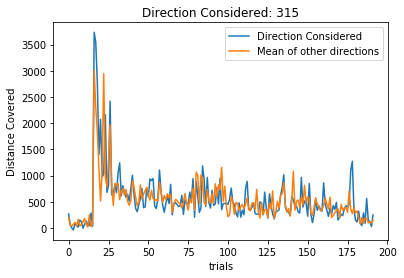

In [1094]:
difference_in_directions(condition = 0, direction_considered=3, target_measure=target_dist_error, title_text='Direction Considered: 315', y_label='Distance Covered')

In [1095]:
speed = distances/mts

In [1096]:
target_speed = target_specific_measures(targets, speed)

[0, 1, 2, 3]


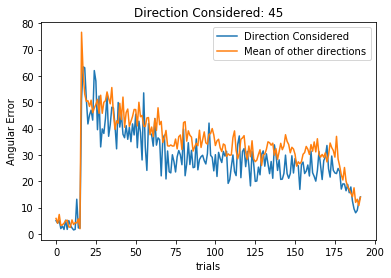

In [1296]:
difference_in_directions(condition = 0, direction_considered=0, target_measure=target_curvatures, title_text='Direction Considered: 45', y_label='Angular Error')

In [1130]:
np.mean(its[1::4][9])

1.699500414322449

(array([  4.,   6., 116., 311., 249.,  96.,  39.,  26.,  27.,  15.,  17.,
          6.,   7.,   8.,   2.,   0.,   3.,   3.,   2.,   2.,   3.,   1.,
          4.,   0.,   0.,   1.,   1.,   1.,   2.,   0.,   0.,   1.,   2.,
          0.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([3.17541864e-04, 1.85238529e-01, 3.70159516e-01, 5.55080504e-01,
        7.40001491e-01, 9.24922478e-01, 1.10984347e+00, 1.29476445e+00,
        1.47968544e+00, 1.66460643e+00, 1.84952742e+00, 2.03444840e+00,
        2.21936939e+00, 2.40429038e+00, 2.58921136e+00, 2.77413235e+00,
        2.95905334e+00, 3.1439

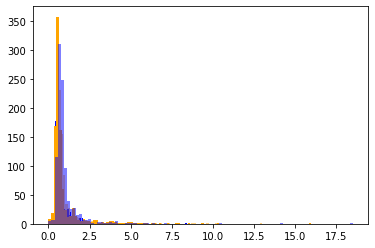

In [1187]:
plt.hist(np.ravel(its[0::4, 9]), bins = 100, color = 'blue')
plt.hist(np.ravel(its[2::4, 9]), bins = 100, color = 'orange')

plt.hist(np.ravel(its[3::4, 9]), bins = 100, alpha = 0.5, color = 'orange')
plt.hist(np.ravel(its[1::4, 9]), bins = 100, alpha = 0.5, color = 'blue')


In [1176]:
?plt.hist